In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from collections import defaultdict

# --- Configuration ---
INPUT_FILENAME = "results_D3.txt"
OUTPUT_PLOT_FILENAME = "performance_plot.png"
US_TO_MS_FACTOR = 1e-3

In [2]:
def parse_results_file(filename):
    """
    Parses the experiment results file line by line to extract data.
    Updated to handle 'us' time unit and negative checksums.
    """
    parsed_data = []
    checksums = defaultdict(set)
    
    # Regex to capture all key fields
    pattern_alg_graph = re.compile(r"^(dijkstra|bmssp) on .*?/graphs/(.+?\.gr) source: \d+ reps: \d+$")
    # UPDATED: changed 'ms' to 'us' in the regex pattern
    pattern_time = re.compile(r"^time: (\d+\.?\d*) us$")
    # UPDATED: changed 'ms' to 'us' in the regex pattern
    pattern_std = re.compile(r"^std: (\d+\.?\d*) us$")
    # UPDATED: added optional minus sign (-) for negative checksums
    pattern_checksum = re.compile(r"^checksum: (-?\d+)$")

    current_entry = {}
    
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                
                match_alg_graph = pattern_alg_graph.match(line)
                if match_alg_graph:
                    if current_entry and 'time' in current_entry and 'checksum' in current_entry:
                        parsed_data.append(current_entry)
                    
                    algorithm = match_alg_graph.group(1)
                    graph_file = match_alg_graph.group(2)
                    
                    graph_size_match = re.search(r'random(\d+)', graph_file)
                    graph_size = int(graph_size_match.group(1)) if graph_size_match else -1
                    
                    current_entry = {
                        'algorithm': algorithm,
                        'graph_file': graph_file,
                        'graph_size': graph_size,
                        'time': None,
                        'std': 0.0, 
                        'checksum': None
                    }
                    continue

                match_time = pattern_time.match(line)
                if match_time and current_entry:
                    # UPDATED: Convert from us to ms using the global factor
                    current_entry['time'] = (float(match_time.group(1)) + 1) * US_TO_MS_FACTOR
                    continue
                    
                match_std = pattern_std.match(line)
                if match_std and current_entry:
                    # UPDATED: Convert from us to ms using the global factor
                    current_entry['std'] = float(match_std.group(1)) * US_TO_MS_FACTOR
                    continue
                
                match_checksum = pattern_checksum.match(line)
                if match_checksum and current_entry:
                    current_entry['checksum'] = match_checksum.group(1)
                    
                    if current_entry['time'] is not None:
                        parsed_data.append(current_entry)
                        checksums[current_entry['graph_file']].add(current_entry['checksum'])
                    
                    current_entry = {}
                    continue
                    
    except FileNotFoundError:
        print(f"ERROR: Input file '{filename}' not found.")
        return None, None
    
    return parsed_data, checksums

In [3]:

def validate_checksums(checksums):
    """
    Checks if all runs on the same graph have the same checksum.
    """
    is_valid = True
    print("\n--- Checksum Validation ---")
    for graph_file, cs_set in checksums.items():
        if len(cs_set) > 1:
            print(f"❌ MISMATCH found for graph: {graph_file}")
            print(f"   Observed Checksums: {cs_set}")
            is_valid = False
        else:
            print(f"✅ OK: {graph_file} (Checksum: {cs_set.pop()})")
    
    if is_valid:
        print("\nAll runs for the same graph produced a matching checksum.")
    else:
        print("\nACTION REQUIRED: Checksum mismatch detected. Results may be inconsistent.")
        
    return is_valid

In [4]:
def create_and_save_time_plot(df, filename):
    """
    Generates and saves the performance plot with error bars.
    UPDATED: x-axis formatter to show power of 2 (e.g., $2^{18}$).
    """
    print("\n--- Generating Execution Time Plot ---")
    try:
        fig, ax = plt.subplots(figsize=(10, 6))

        for algo, group in df.groupby('algorithm'):
            ax.errorbar(
                group['graph_size'], 
                group['time'], 
                yerr=group['std'], 
                fmt='-o', 
                capsize=5, 
                label=algo
            )

        # Set plot properties
        ax.set_xscale('log') 
        ax.set_xlabel('Graph Size (Number of Vertices - Log Scale)')
        ax.set_yscale('log')
        ax.set_ylabel('Execution Time (ms)')
        ax.set_title('Algorithm Performance vs. Graph Size')
        ax.legend(title='Algorithm')
        ax.grid(True, which="both", ls="--", linewidth=0.5)

        # Ensure x-axis labels are readable
        ax.set_xticks(df['graph_size'].unique())
        
        # --- START OF X-AXIS CHANGE ---
        # Custom formatter to convert the number to its power of 2 (e.g., $2^{18}$)
        def power_of_two_formatter(x, pos):
            # Calculate the exponent (log base 2)
            exponent = np.log2(x)
            # Use LaTeX for the $2^{exponent}$ format
            return f'$2^{{{int(exponent)}}}$'
        
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(power_of_two_formatter))
        # --- END OF X-AXIS CHANGE ---

        plt.tight_layout()
        plt.savefig("time_" + filename)
        print(f"Time plot saved successfully to: time_{filename}")

    except Exception as e:
        print(f"ERROR during time plot generation: {e}")
        
def create_and_save_ratio_plot(df_ratio, filename):
    """
    Generates and saves a plot of the ratio of bmssp time to dijkstra time.
    UPDATED: x-axis formatter to show power of 2 (e.g., $2^{18}$).
    """
    print("\n--- Generating Ratio Plot ---")
    try:
        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(
            df_ratio['graph_size'],
            df_ratio['ratio'],
            marker='o',
            linestyle='-',
            color='r',
            label='BMSPP Time / Dijkstra Time'
        )
        print(df_ratio['graph_size'])

        ax.axhline(1.0, color='gray', linestyle='--', linewidth=0.8, label='Ratio = 1.0 (Break-Even)')

        # Set plot properties
        ax.set_xscale('log')
        ax.set_xlabel('Graph Size (Number of Vertices - Log Scale)')
        ax.set_ylabel('Performance Ratio (BMSPP Time / Dijkstra Time)')
        ax.set_title('BMSPP vs. Dijkstra Performance Ratio')
        ax.legend()
        ax.grid(True, which="both", ls="--", linewidth=0.5)

        # Ensure x-axis labels are readable
        ax.set_xticks(df_ratio['graph_size'].unique())
        
        # --- START OF X-AXIS CHANGE ---
        # Custom formatter to convert the number to its power of 2 (e.g., $2^{18}$)
        def power_of_two_formatter(x, pos):
            # Calculate the exponent (log base 2)
            exponent = np.log2(x)
            # Use LaTeX for the $2^{exponent}$ format
            return f'$2^{{{int(exponent)}}}$'
        
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(power_of_two_formatter))
        # --- END OF X-AXIS CHANGE ---

        plt.tight_layout()
        ratio_filename = "ratio_" + filename
        plt.savefig(ratio_filename)
        print(f"Ratio plot saved successfully to: {ratio_filename}")

    except Exception as e:
        print(f"ERROR during ratio plot generation: {e}")


--- Checksum Validation ---
✅ OK: random262144D3.gr (Checksum: 8302759168199149123)
✅ OK: random1048576D3.gr (Checksum: -6449462870799718753)
✅ OK: random32768D3.gr (Checksum: -2766866317997822426)
✅ OK: random524288D3.gr (Checksum: -2763563153203008820)
✅ OK: random4096D3.gr (Checksum: -6456342282856093397)
✅ OK: random1024D3.gr (Checksum: 8301039345197646210)
✅ OK: random131072D3.gr (Checksum: 4612547877744522073)
✅ OK: random33554432D3.gr (Checksum: 4832402153862642881)
✅ OK: random16384D3.gr (Checksum: 8301107380214675256)
✅ OK: random8192D3.gr (Checksum: 4611722349464590623)
✅ OK: random32D3.gr (Checksum: 4611686085001134528)
✅ OK: random65536D3.gr (Checksum: -6456069972189081960)
✅ OK: random8388608D3.gr (Checksum: -2711836461364713124)
✅ OK: random512D3.gr (Checksum: 4611687195343464840)
✅ OK: random2D3.gr (Checksum: 4611686020574871547)
✅ OK: random8D3.gr (Checksum: -2767011611055646511)
✅ OK: random64D3.gr (Checksum: 8301034972763662026)
✅ OK: random16D3.gr (Checksum: -645636

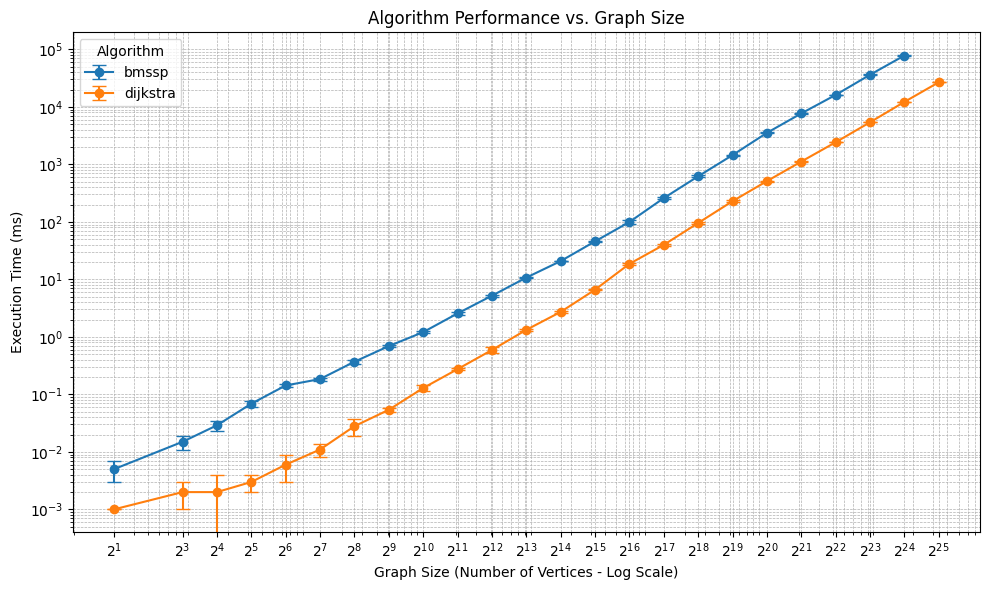

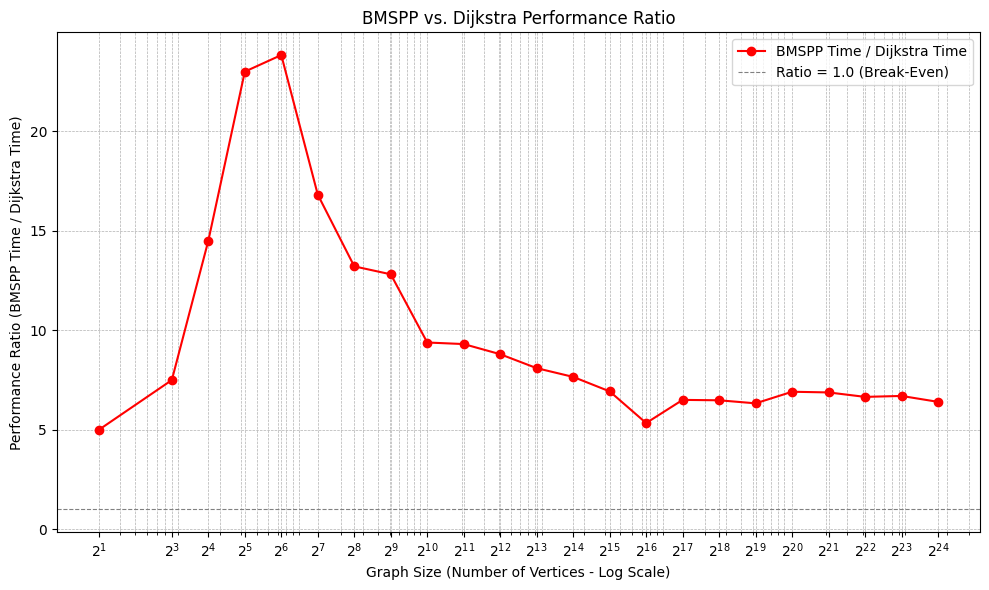

In [5]:

# --- Main Execution ---
if __name__ == "__main__":
    parsed_results, checksum_map = parse_results_file(INPUT_FILENAME)

    if parsed_results:
        # 1. Checksum Validation
        validate_checksums(checksum_map)
        
        # 2. Data Preparation
        df = pd.DataFrame(parsed_results)
        # Sort by graph size for correct plotting order
        df = df.sort_values(by='graph_size').reset_index(drop=True)
        
        # 3. Create Time Plot
        create_and_save_time_plot(df, OUTPUT_PLOT_FILENAME)

        # 4. Create Ratio Plot (Requires both algorithms for each graph size)
        # Pivot the data to get 'bmssp' and 'dijkstra' times as columns
        df_pivot = df.pivot(index='graph_size', columns='algorithm', values='time').reset_index()
        df_pivot.columns.name = None # Clean up column name

        # Calculate the ratio: bmssptime / dijkstratime
        if 'bmssp' in df_pivot.columns and 'dijkstra' in df_pivot.columns:
            df_pivot['ratio'] = df_pivot['bmssp'] / df_pivot['dijkstra']
            
            # Use only rows where both times exist (no NaNs in ratio)
            df_ratio = df_pivot.dropna(subset=['ratio']) 

            if not df_ratio.empty:
                create_and_save_ratio_plot(df_ratio, OUTPUT_PLOT_FILENAME)
            else:
                 print("\nSkipping Ratio Plot: Could not find matching 'bmssp' and 'dijkstra' data for ratio calculation.")
        else:
            print("\nSkipping Ratio Plot: 'bmssp' or 'dijkstra' data missing in results.")


In [6]:
# Certifique-se de que o DataFrame 'df' foi criado e validado nas células anteriores
# Ex: df = pd.DataFrame(data_list)
# Ex: df = df[df['graph_size'] > 0].copy()

# 1. Pivotar o DataFrame para ter os tempos lado a lado
# Calculamos a média do tempo para cada algoritmo e tamanho de grafo
df_summary = df.groupby(['graph_size', 'algorithm'])['time'].mean().unstack(level='algorithm')

# 2. Renomear as colunas de tempo para clareza
df_summary.rename(columns={
    'dijkstra': 'Tempo Dijkstra (ms)',
    'bmssp': 'Tempo BMSPP (ms)'
}, inplace=True)

# 3. Calcular a Razão (Ratio)
# A razão é: Tempo BMSPP / Tempo Dijkstra
df_summary['Ratio BMSPP / Dijkstra'] = df_summary['Tempo BMSPP (ms)'] / df_summary['Tempo Dijkstra (ms)']

# 4. Adicionar a Coluna de Número de Arestas
# O número de arestas (m) é 3 vezes o número de vértices (n),
# onde o número de vértices é o 'graph_size' que está no index.
df_summary['Número de Vértices'] = df_summary.index
df_summary['Número de Arestas'] = df_summary['Número de Vértices'] * 3

# 5. Selecionar e Reordenar as Colunas
final_table = df_summary[[
    'Número de Vértices',
    'Número de Arestas',
    'Tempo Dijkstra (ms)',
    'Tempo BMSPP (ms)',
    'Ratio BMSPP / Dijkstra'
]].sort_values(by='Número de Vértices').copy()

# 6. Formatação (opcional, mas recomendado)
# Formata os tempos e o ratio para 3 casas decimais
pd.options.display.float_format = '{:,.3f}'.format

# 7. Exibir a Tabela
print("\n--- Tabela de Comparação de Desempenho (Média por Tamanho de Grafo) ---")
display(final_table)


--- Tabela de Comparação de Desempenho (Média por Tamanho de Grafo) ---


algorithm,Número de Vértices,Número de Arestas,Tempo Dijkstra (ms),Tempo BMSPP (ms),Ratio BMSPP / Dijkstra
graph_size,,,,,
2,2,6,0.001,0.005,5.000
8,8,24,0.002,0.015,7.500
16,16,48,0.002,0.029,14.500
32,32,96,0.003,0.069,23.000
64,64,192,0.006,0.143,23.833
128,128,384,0.011,0.185,16.818
256,256,768,0.028,0.370,13.214
512,512,1536,0.054,0.692,12.815
1024,1024,3072,0.129,1.211,9.388
